In [ ]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
exchangeTo = datastore.getExchangeTo() 

turnOver = datastore.getTurnover()

temp_pen = datastore.getDailyWeather() # DAILY celsius
wind_velocities = datastore.getHourlyWindVelocity() # m/s
hydroReservoirs = datastore.getWeeklyHydroReservs() # GWh

In [ ]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh,  
                     flow, 
                     capTo, capFrom, exchangeFrom, exchangeTo,
                     turnOver, 
                     wind_velocities, hydroReservoirs, temp_pen, transTo, transFrom], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])


dataset.info()

In [1]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
import pandas as pd
import numpy as np

dataset = pd.read_csv('dataset.csv', sep=';', parse_dates=True, index_col=0)
spot = dataset['spotPrice']

# spot_lag_24 = spot.shift(24).to_frame().add_suffix('_24')
# spot_lag_48 = spot.shift(48).to_frame().add_suffix('_48')
# spot_lag_72 = spot.shift(72).to_frame().add_suffix('_72')
# spot_lag_96 = spot.shift(96).to_frame().add_suffix('_96')
# spot_lag_120 = spot.shift(120).to_frame().add_suffix('_120')
# spot_lag_168 = spot.shift(168).to_frame().add_suffix('_144')
# spot_lag_192 = spot.shift(192).to_frame().add_suffix('_192')
# spot_lag_216 = spot.shift(216).to_frame().add_suffix('_216')
# spot_lag_240 = spot.shift(240).to_frame().add_suffix('_240')

# dataset_ = pd.concat([spot_lag_24, spot_lag_48, spot_lag_72, spot_lag_96, spot_lag_120, spot_lag_168, spot_lag_192, spot_lag_216, spot_lag_240
#                     ,dataset]
#                     ,axis=1)
# dataset = dataset_.dropna()
# first_col = dataset.pop('spotPrice')
# dataset.insert(0, 'spotPrice', first_col)

# print(dataset.iloc[:, 1:49].columns.to_list())

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'

test_split = '2023-12-24 23:00:00'
test_split_ = '2023-12-31 23:00:00'


train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)
test_split_future_covariates = dataset.index.get_loc(test_split_)

past_covariates = dataset.iloc[:, 1:40] #OBS!
future_covariates = dataset.iloc[:, 40:]
target_series = dataset['spotPrice'].to_frame()

past_covariates = TimeSeries.from_dataframe(past_covariates)
future_covariates = TimeSeries.from_dataframe(future_covariates)
target_series = TimeSeries.from_dataframe(target_series)

past_covariates_train, past_covariates_val, past_covariates_test = past_covariates[:train_split_index], past_covariates[train_split_index:val_split_index], past_covariates[val_split_index:test_split_index]
future_covariates_train, future_covariates_val, future_covariates_test = future_covariates[:train_split_index], future_covariates[train_split_index:val_split_index], future_covariates[val_split_index:test_split_future_covariates]
target_train, target_val, target_test = target_series[:train_split_index], target_series[train_split_index:val_split_index], target_series[val_split_index:test_split_index]

past_covariates_scaler, future_covariates_scaler, target_scaler = Scaler(), Scaler(), Scaler()

past_covariates_train = past_covariates_scaler.fit_transform(past_covariates_train).astype(np.float32)
past_covariates_val = past_covariates_scaler.transform(past_covariates_val).astype(np.float32)
past_covariates_test = past_covariates_scaler.transform(past_covariates_test).astype(np.float32)

future_covariates_train = future_covariates_scaler.fit_transform(future_covariates_train).astype(np.float32)
future_covariates_val = future_covariates_scaler.transform(future_covariates_val).astype(np.float32)
future_covariates_test = future_covariates_scaler.transform(future_covariates_test).astype(np.float32)

target_train = target_scaler.fit_transform(target_train).astype(np.float32)
target_val = target_scaler.transform(target_val).astype(np.float32)
target_test = target_scaler.transform(target_test).astype(np.float32)

past_covariates = concatenate([past_covariates_train, past_covariates_val, past_covariates_test]).astype(np.float32)
future_covariates = concatenate([future_covariates_train, future_covariates_val, future_covariates_test]).astype(np.float32)

In [ ]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
import pandas as pd

dataset = pd.read_csv('dataset.csv', sep=';', parse_dates=True, index_col=0)
dataset = dataset.drop()

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'

test_split = '2023-12-24 23:00:00'
test_split_ = '2023-12-31 23:00:00'


train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)
test_split_future_covariates = dataset.index.get_loc(test_split_)

past_covariates = dataset.iloc[:, 1:40]
future_covariates = dataset.iloc[:, 40:]
target_series = dataset['spotPrice'].to_frame()

past_covariates = TimeSeries.from_dataframe(past_covariates)
future_covariates = TimeSeries.from_dataframe(future_covariates)
target_series = TimeSeries.from_dataframe(target_series)

past_covariates_train, past_covariates_val, past_covariates_test = past_covariates[:train_split_index], past_covariates[train_split_index:val_split_index], past_covariates[val_split_index:test_split_index]
future_covariates_train, future_covariates_val, future_covariates_test = future_covariates[:train_split_index], future_covariates[train_split_index:val_split_index], future_covariates[val_split_index:test_split_future_covariates]
target_train, target_val, target_test = target_series[:train_split_index], target_series[train_split_index:val_split_index], target_series[val_split_index:test_split_index]

past_covariates_scaler, future_covariates_scaler, target_scaler = Scaler(), Scaler(), Scaler()

past_covariates_train = past_covariates_scaler.fit_transform(past_covariates_train)
past_covariates_val = past_covariates_scaler.transform(past_covariates_val)
past_covariates_test = past_covariates_scaler.transform(past_covariates_test)

future_covariates_train = future_covariates_scaler.fit_transform(future_covariates_train)
future_covariates_val = future_covariates_scaler.transform(future_covariates_val)
future_covariates_test = future_covariates_scaler.transform(future_covariates_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

past_covariates = concatenate([past_covariates_train, past_covariates_val, past_covariates_test])
future_covariates = concatenate([future_covariates_train, future_covariates_val, future_covariates_test])

In [4]:
import torch

from darts.models import TFTModel
from darts.utils.callbacks import TFMProgressBar

from torchmetrics import MetricCollection
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError, MeanSquaredError
from darts.utils.losses import MAELoss
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


torch.set_float32_matmul_precision("high")

my_stopper = EarlyStopping(
    monitor="val_loss",
    patience= 3,
    min_delta = 0.005,
    mode='min',
)


def generate_torch_kwargs():
    # run torch models on GPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": 'auto',
            "callbacks": [TFMProgressBar(enable_train_bar_only=True), my_stopper],
        }
    }

LOSS_FN = MAELoss()
METRICS = MetricCollection([SymmetricMeanAbsolutePercentageError(), MeanSquaredError()])

INPUT = 24 * 5 * 2
OUTPUT = 24 * 5

EPOCHS = 100

HIDDEN_DIM = 16
HIDDEN_DIM_CONT = 2

BATCH_SIZE = 32

N_LAYERS = 1
ATTN_HEADS = 4

DROPOUT = 0.2

tft = TFTModel(
    input_chunk_length = INPUT,
    output_chunk_length = OUTPUT,
    
    n_epochs = EPOCHS,
    lstm_layers = N_LAYERS,

    batch_size = BATCH_SIZE,
    dropout = DROPOUT,
    
    loss_fn = LOSS_FN,
    torch_metrics = METRICS,
    use_static_covariates = False,
    
    num_attention_heads=ATTN_HEADS,
    
    hidden_size = HIDDEN_DIM,
    hidden_continuous_size = HIDDEN_DIM_CONT,
    optimizer_kwargs = {'lr': 0.001},
    
    **generate_torch_kwargs()
)


In [ ]:
from darts.models import TFTModel
from darts.utils.callbacks import TFMProgressBar
import torch

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanSquaredError, MeanAbsoluteError

from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import HyperBandScheduler

torch.set_float32_matmul_precision("medium")

def train_model(model_args, callbacks, train, val, future_cov_train, past_cov_train, past_cov_val, future_cov_val):
    METRICS = MetricCollection([MeanAbsoluteError(), SymmetricMeanAbsolutePercentageError(), MeanSquaredError()])
    LOSS_FN = torch.nn.L1Loss()
    EPOCHS = 1
    INPUT = 24 * 5 
    OUTPUT = 24 * 5
    
    # Create the model using model_args from Ray Tune
    model = TFTModel(
        input_chunk_length = INPUT,
        output_chunk_length = OUTPUT,
        n_epochs = EPOCHS,
        
        torch_metrics = METRICS,
    
        pl_trainer_kwargs={"callbacks": callbacks, "enable_progress_bar": False},
        **model_args)

    model.fit(
        series = train,
        future_covariates = future_cov_train,
        past_covariates = past_cov_train,
        val_series = val,
        val_past_covariates = past_cov_val,
        val_future_covariates = future_cov_val,
    
    )
    
    
#tft.fit(
#    series = target_train,
#    future_covariates = future_covariates_train,
#    past_covariates = past_covariates_train,
#    val_series = target_val,
#    val_past_covariates = past_covariates_val,
#    val_future_covariates = future_covariates_val,
    
#)
    

my_stopper = EarlyStopping(
    monitor="val_MeanAbsoluteError",
    patience= 2,
    min_delta = 0.05,
    mode='min',
)


tune_callback = TuneReportCallback(
    {
        "loss": "val_loss",
        "MAE": "val_MeanAbsoluteError",
    },
    on="validation_end",
)

config = {
    "batch_size": tune.choice([16, 32, 64, 128]),
    "hidden_size": tune.choice([16, 32, 64, 128]),
    "num_attention_heads": tune.choice([1, 2, 3]),
    "dropout": tune.grid_search([0.1, 0.3, 0.5, 0.8])
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["loss", "MAE", "training_iteration"],
)

resources_per_trial = {"cpu": 12, "gpu": 1}
num_samples = 5

scheduler = HyperBandScheduler(max_t=1000, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(
    train_model, callbacks=[my_stopper, tune_callback], 
    train= target_train, val=target_val, 
    future_cov_train = future_covariates_train, past_cov_train = past_covariates_train, 
    past_cov_val = past_covariates_val, future_cov_val = future_covariates_val,
    
)


# optimize hyperparameters by minimizing the MAPE on the validation set
analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    # Using a metric instead of loss allows for
    # comparison between different likelihood or loss functions.
    metric="MAE",
    mode="min",
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    name="tune_darts",
)

print("Best hyperparameters found were: ", analysis.best_config)

In [5]:
tft.fit(
    series = target_train,
    future_covariates = future_covariates_train,
    past_covariates = past_covariates_train,
    val_series = target_val,
    val_past_covariates = past_covariates_val,
    val_future_covariates = future_covariates_val,
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MAELoss                          | 0     
1  | train_criterion                   | MAELoss                          | 0     
2  | val_criterion                     | MAELoss                          | 0     
3  | train_metrics                     | MetricCollection                 | 0     
4  | val_metrics                       | MetricCollection                 | 0     
5  | input_embeddings                  | _MultiEmbedding                  | 0     
6  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
7  | encoder_vsn                       | _VariableSe

Training: 0it [00:00, ?it/s]

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\module.py:491: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\module.py:491: You called `self.log('train_MeanSquaredError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=2, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=MAELoss(), likelihood=None, norm_type=LayerNorm, use_static_covariates=False, input_chunk_length=240, output_chunk_length=120, n_epochs=100, batch_size=32, torch_metrics=MetricCollection(
  (SymmetricMeanAbsolutePercentageError): SymmetricMeanAbsolutePercentageError()
  (MeanSquaredError): MeanSquaredError()
), optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000023F328D1840>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000023F328D3C40>]})

In [3]:
from darts.metrics import smape, mae, rmse, mse
import matplotlib.pyplot as plt
import torch

OUTPUT = 120
torch.set_float32_matmul_precision('high')

backtest = tft.historical_forecasts(target_test, 
                                    future_covariates = future_covariates_test,
                                    past_covariates = past_covariates_test,
                                    start = target_test.start_time(), 
                                    num_samples = 100, 
                                    stride = OUTPUT,
                                    forecast_horizon = OUTPUT,
                                    retrain = False, 
                                    verbose = True, 
                                    last_points_only = False,
                                    overlap_end = True,
                                    predict_kwargs = {'mc_dropout' : True},
                                    )


`start` time `2022-12-31 23:00:00` is before the first predictable/trainable historical forecasting point for series at index: 0. Ignoring `start` for this series and beginning at first trainable/predictable time: 2023-01-10 23:00:00. To hide these warnings, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


MSE = 194287.01935985268
RMSE = 440.7800124323387
SMAPE = 72.70968047281562
MAE = 334.37642089894507


<Axes: xlabel='time'>

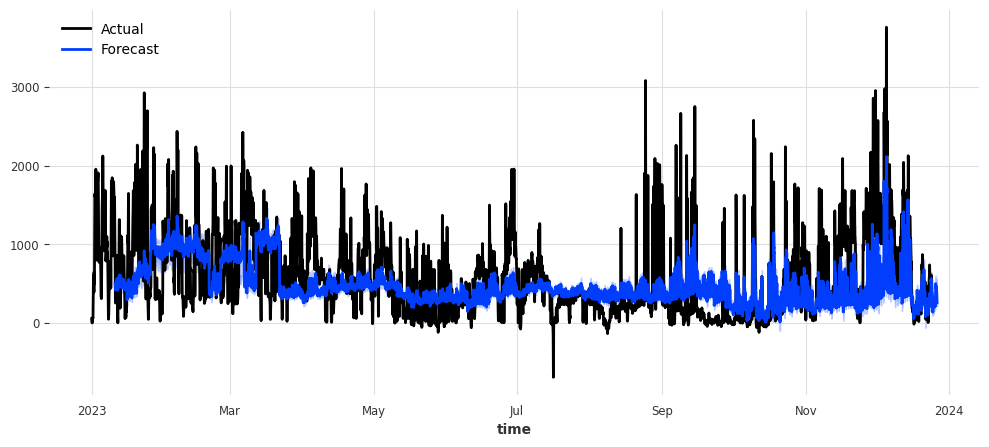

In [4]:
backtest_ = concatenate(backtest)
backtest_ = target_scaler.inverse_transform(backtest_)
target_test_ = target_scaler.inverse_transform(target_test)

print('MSE = {}'.format(mse(target_test_, backtest_)))
print('RMSE = {}'.format(rmse(target_test_, backtest_)))
print('SMAPE = {}'.format(smape(target_test_, backtest_)))
print('MAE = {}'.format(mae(target_test_, backtest_)))


plt.figure(figsize=(12,5))
target_test_.plot(label='Actual')
backtest_.plot(label='Forecast')

C:\Users\drami\AppData\Local\Temp\ipykernel_47760\2243404350.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


AttributeError: 'Axes' object has no attribute 'set_linewidth'

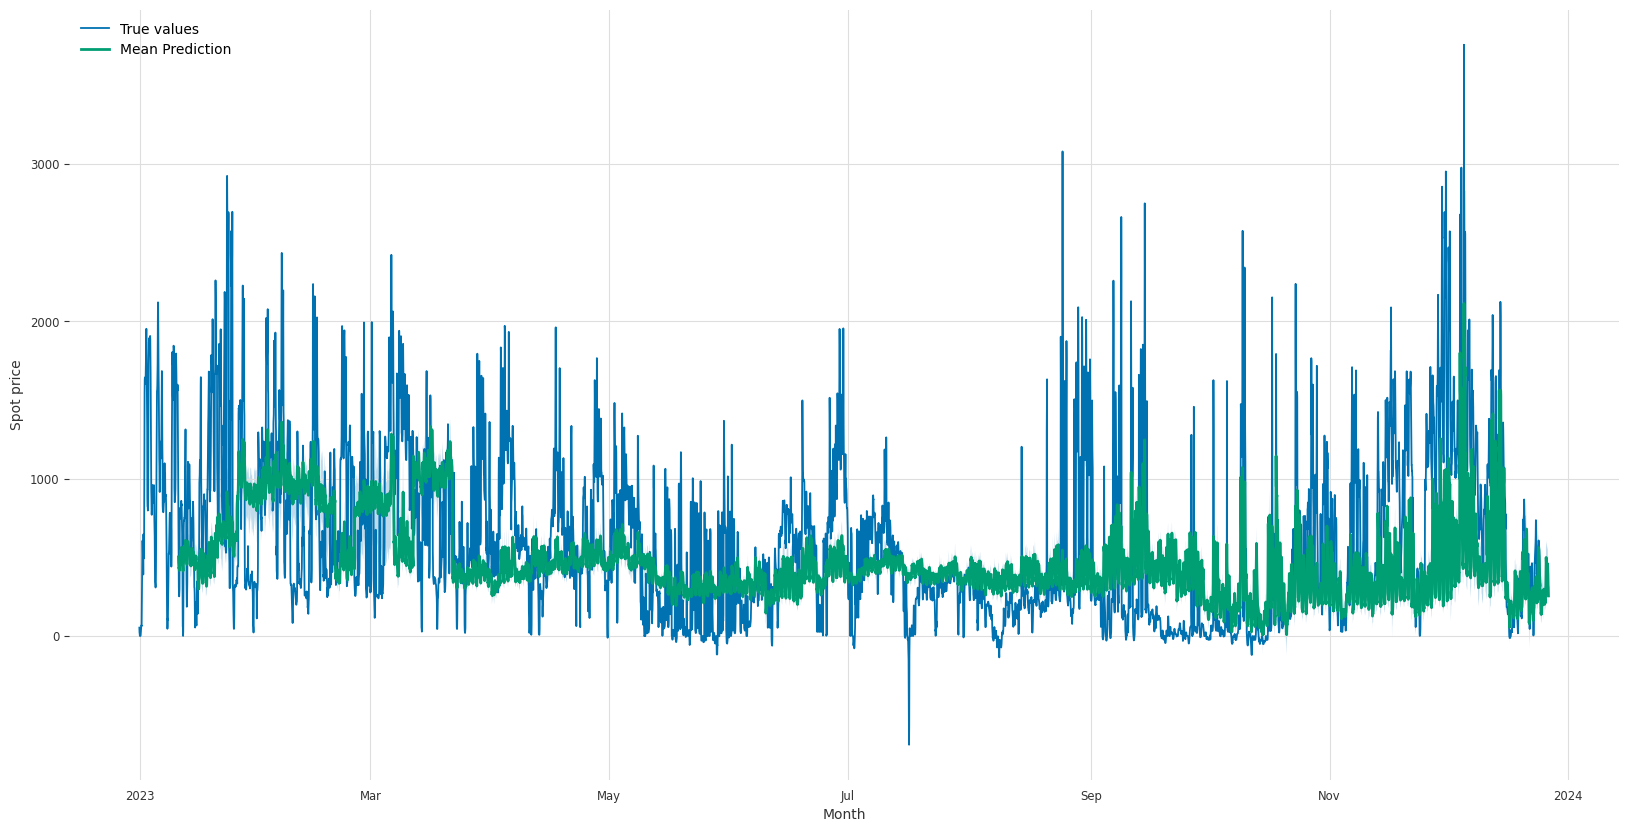

In [9]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.style.use('seaborn-colorblind')
rcParams['font.weight'] = 'normal'
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(target_test_.pd_dataframe(), label="True values")
plot = backtest_.plot(low_quantile = 0.025, high_quantile = 0.975, label="Mean Prediction", 
               default_formatting=False,
               new_plot=False,
               ax=ax)
ax.grid(True)
ax.set_xlabel("Month", weight = "normal")
ax.set_ylabel("Spot price",  weight = "normal")
ax.
children = plot.get_children()[2]
children.set_alpha(1)
children.set_color("black")
children.set_linewidth = 1
children.set_label("95% PI")
ax.legend()


In [135]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def smape(A, F):
    import numpy as np
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

predictions = backtest_.data_array()
reals = target_test_.data_array()
reals = reals[480:]
predictions = predictions[:-48]

mae_ = mean_absolute_error (reals.values.reshape(-1,1), predictions.values.reshape(-1,1))
mse_ = mean_squared_error (reals.values.reshape(-1,1), predictions.values.reshape(-1,1))
rmse_ = np.sqrt(mse_)
smape_ = smape(reals.values.reshape(-1,1), predictions.values.reshape(-1,1))

In [13]:
tft.save("TFT2.pt")

In [24]:
OUTPUT = 120

pred = tft.predict(n = OUTPUT, series = target_test, past_covariates = past_covariates_test, 
                   future_covariates = future_covariates_test, verbose = 1, 
                   mc_dropout=True, num_samples=100)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


In [2]:
from darts.models import TFTModel

tft = TFTModel.load("TFT2.pt")

In [29]:
from darts.explainability.tft_explainer import TFTExplainer
explainer = TFTExplainer(tft)
results = explainer.explain(foreground_series=target_test, foreground_past_covariates=past_covariates_test, foreground_future_covariates=future_covariates_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


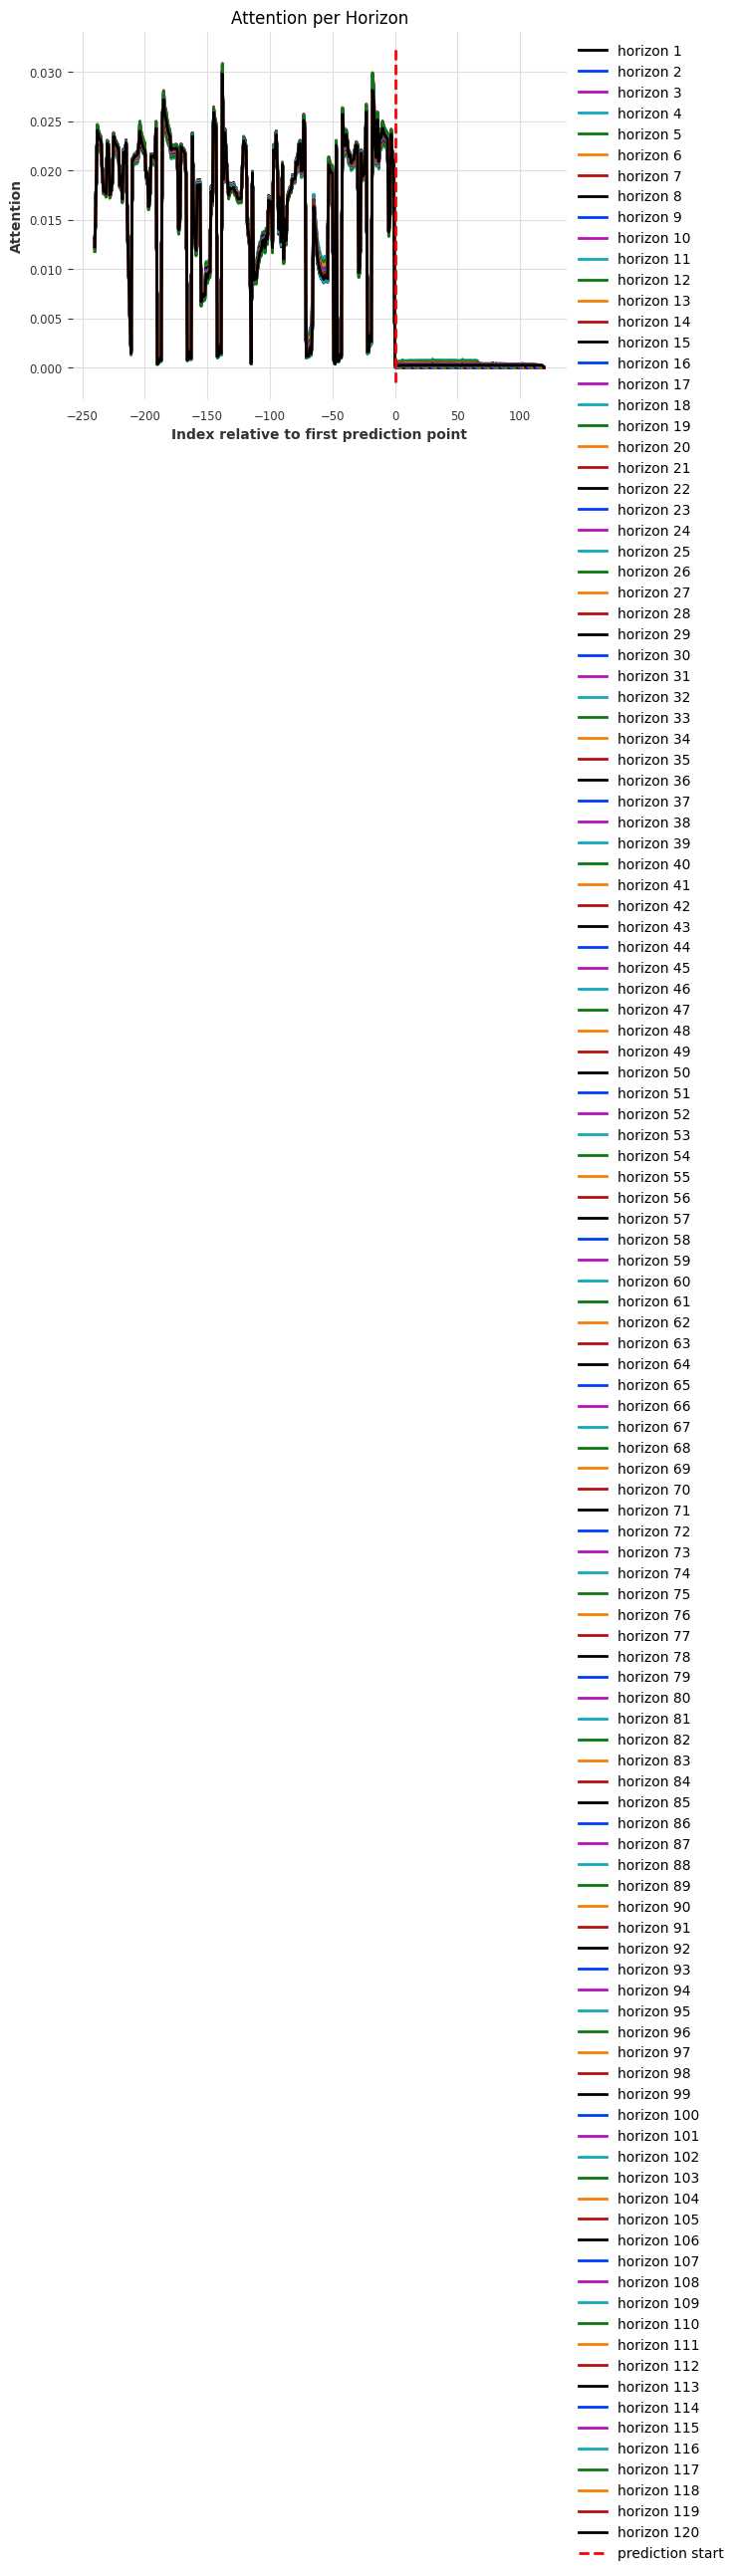

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [30]:
explainer.plot_attention(results)

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


Text(0.5, 0, 'Feature importance (%)')

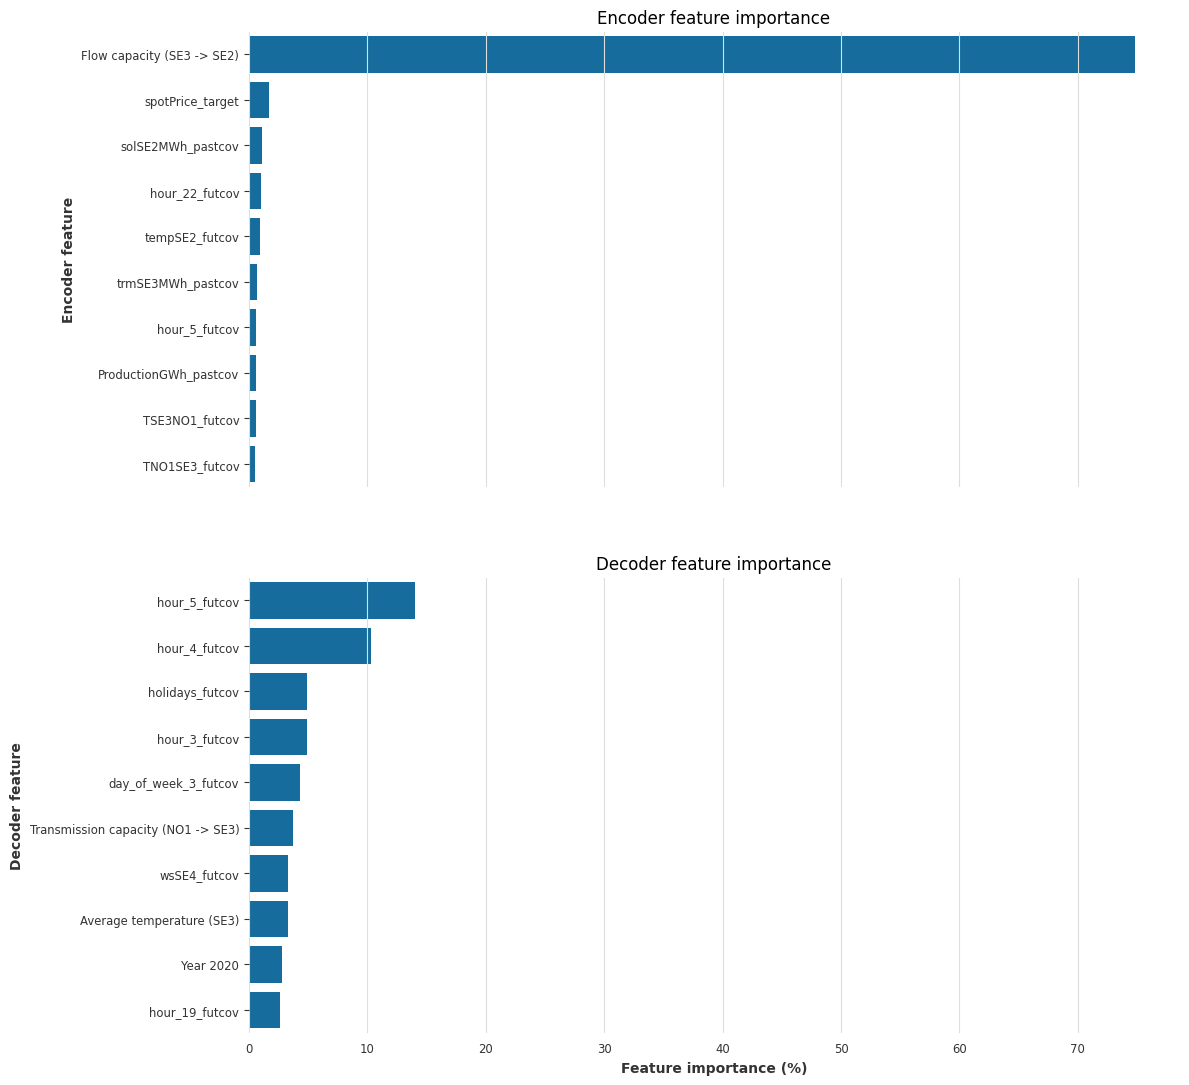

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-colorblind')
fig, ax = plt.subplots(figsize=(12,13), nrows=2, sharex=True)
ax1, ax2 = ax.flatten()

fi = results.get_feature_importances()
fi_encoder = fi["encoder_importance"].transpose()
fi_decoder = fi["decoder_importance"].transpose()

encoder_rows = {'C_SE3SE2_pastcov': 'Flow capacity (SE3 -> SE2)',
        'wsSE3_futcov' : 'Wind speed (SE3)', 
        'hour_23_futcov': 'Hour 23', 
        'F_LOWSE3SE4_pastcov' : 'Flow (SE3 -> SE4)', 
        'C_SE3DK1_pastcov' : 'Flow capacity (SE3 -> DK1)',
        'HydroBalance(GWh_week)_pastcov' : 'Hydro balance (all zones)', 
        'C_SE2SE3_pastcov' : 'Flow capacity (SE2 -> SE3)', 
        'waterSE4(MWh)_pastcov' : 'Hydro production (SE4)', 
        'tempSE1_futcov' : 'Average temperature (SE1)',
        'hour_11_futcov': 'Hour 11'}
decoder_rows = {'year_2023_futcov' : 'Year 2023', 
                'tempSE2_futcov' : 'Average temperature (SE2)', 
                'year_2020_futcov' : 'Year 2020', 
                'TF1SE3_futcov' : 'Transmission capacity (F1 -> SE3 )',
                'TSE3F1_futcov' : 'Transmission capacity (SE3 -> F1)', 
                'month_1_futcov' : 'Month 1', 
                'year_2019_futcov' : 'Year 2019', 
                'TNO1SE3_futcov' : 'Transmission capacity (NO1 -> SE3)', 
                'tempSE3_futcov' : 'Average temperature (SE3)' , 
                'day_of_week_4_futcov' : 'Day 4'}

# Extract top 10
fi_encoder.sort_values(by=fi_encoder.columns[0], ascending=False, inplace=True)
fi_encoder_top = fi_encoder.iloc[:10]
fi_encoder_top = fi_encoder_top.rename(columns={0: "Feature importance"})
fi_encoder_top = fi_encoder_top.rename(index = encoder_rows)

fi_decoder.sort_values(by=fi_decoder.columns[0], ascending=False, inplace=True)
fi_decoder_top = fi_decoder.iloc[:10]
fi_decoder_top = fi_decoder_top.rename(columns={0: "Feature importance"})
fi_decoder_top = fi_decoder_top.rename(index = decoder_rows)

sns.barplot(fi_encoder_top, x = "Feature importance", 
            y = fi_encoder_top.index, orient='y', ax = ax1)
ax1.set_title("Encoder feature importance")
ax1.set_ylabel("Encoder feature")
ax1.set_xlabel("Feature importance (%)")
sns.barplot(fi_decoder_top, x = "Feature importance",
            y = fi_decoder_top.index, orient='y', ax = ax2)
ax2.set_title("Decoder feature importance")
ax2.set_ylabel("Decoder feature")
ax2.set_xlabel("Feature importance (%)")




In [30]:
attn = results.get_attention()
attn_df = attn.pd_dataframe()

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
FixedFormatter should only be used together with FixedLocator


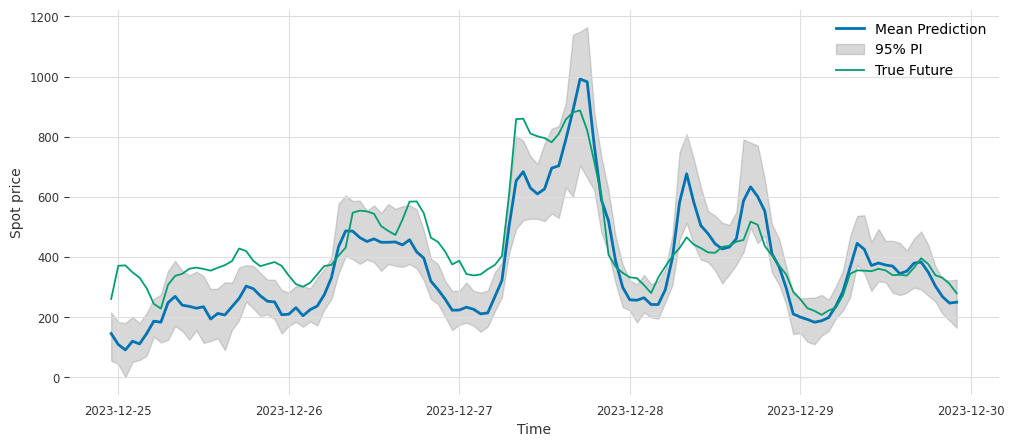

In [37]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.style.use('seaborn-colorblind')
rcParams['font.weight'] = 'normal'
fig, ax = plt.subplots(figsize=(12,5))

kwargs = {'color':'#0173b2'}
ticks = ["2023-12-25", "2023-12-26", "2023-12-27", "2023-12-28", "2023-12-29", 
         "2023-12-30"]


start = "2023-12-04 23:00:00"
end = "2023-12-29 22:00:00"
time_index = dataset[start:end].spotPrice.tail(120).index


plot = target_scaler.inverse_transform(pred).plot(label= ['Mean Prediction'], 
                                           low_quantile = 0.025, 
                                           high_quantile = 0.975,
                                           default_formatting=False, 
                                           new_plot=False,
                                           ax = ax,
                                           **kwargs)
ax.plot((dataset["2023-12-04 23:00:00":"2023-12-29 22:00:00"].spotPrice.tail(120)), label = "True Future",
        color = "#029e73")
ax.set_xlabel("Time", weight = "normal")
ax.set_ylabel("Spot price",  weight = "normal")
ax.grid(True)
ax.set_xticklabels(ticks)

children = plot.get_children()[1]
children.set_alpha(0.3)
children.set_color("gray")
children.set_linewidth = 1
children.set_label("95% PI")
ax.legend()